# class generated images

this code has been adapted from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations)

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import math
import torchvision.transforms as transforms
from torchvision import models

#Read an image
from PIL import Image, ImageFilter
import requests
from io import BytesIO
url ="https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

#choose the model
pret_mod = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
from matplotlib import cm
import copy
from torch.nn import ReLU
from torch.autograd import Variable
from torch.optim import SGD

def image_open(img_path):
    response = requests.get(img_path)
    img_screen = Image.open(BytesIO(response.content))
    return img_screen


def process_img(img, model):
  norm_mean = [0.485, 0.456, 0.406]
  norm_std = [0.229, 0.224, 0.225]

  data_transform = transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(norm_mean, norm_std),
          ])
  im = data_transform(img)
  im = im.unsqueeze(0)
  output = model(im)
  _, pred_cls = output.max(dim=1, keepdim=True)
  im = Variable(im, requires_grad=True)
  return im, pred_cls

def format_np_output(np_arr):
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im):
  im = format_np_output(im)
  im = Image.fromarray(im)
  return im

def preprocess_image(pil_im, resize_im=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    im_as_ten = torch.from_numpy(im_as_arr).float()
    im_as_ten.unsqueeze_(0)
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

def recreate_image(im_as_var):
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


In [6]:
class ClassSpecificImageGeneration():

    def __init__(self, model, target_class, iter):
        self.mean = [-0.485, -0.456, -0.406]
        self.std = [1/0.229, 1/0.224, 1/0.225]
        self.model = model
        self.model.eval()
        self.target_class = target_class
        self.created_image = np.uint8(np.random.uniform(0, 255, (224, 224, 3)))
        self.iterations= iter

    def generate(self):
        iterations=np.int(self.iterations)
        initial_learning_rate = 6
        images = list()

        for i in range(1, iterations):
            self.processed_image = preprocess_image(self.created_image, False)
            optimizer = SGD([self.processed_image], lr=initial_learning_rate)
            output = self.model(self.processed_image)
            class_loss = -output[0, self.target_class]

            if i % 15 == 0 or i == iterations-1:
                print('Iteration:', str(i), 'Loss',
                      "{0:.2f}".format(class_loss.data.numpy()))
            self.model.zero_grad()
            class_loss.backward()
            optimizer.step()
            self.created_image = recreate_image(self.processed_image)
            if i % 15 == 0 or i == iterations-1:

                im =save_image(self.created_image)
                images.append(im)

        return images


In [7]:
class_to_gen =72
iter = 100
def class_generated_images(model, class_to_gen, iter):
  csig = ClassSpecificImageGeneration(model, class_to_gen, iter)
  images =csig.generate()
  return images


images = class_generated_images(pret_mod, class_to_gen, iter)

<ipython-input-6-a2c49400c530>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iterations=np.int(self.iterations)


Iteration: 15 Loss -5.70
Iteration: 30 Loss -29.82
Iteration: 45 Loss -117.41
Iteration: 60 Loss -222.84
Iteration: 75 Loss -318.14
Iteration: 90 Loss -412.17
Iteration: 99 Loss -454.06


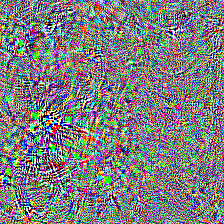

In [9]:
images[-1]

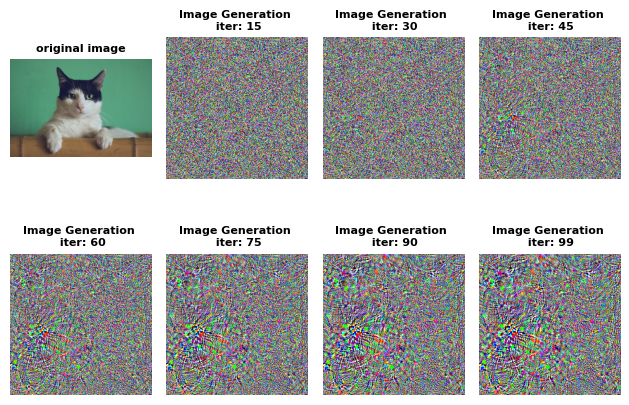

In [14]:
def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
      ax[-2].set_visible(False)
    plt.tight_layout()


imgs = [img]
imgs = imgs + images
captions = ['original image'] + ['Image Generation \n iter: ' + str(i) for i in range(15,101,15)] + [ 'Image Generation \n iter: 99']
fig = download_images(imgs, captions, cols = 4, rows = 2, size = 8)

In [10]:

class RegularizedClassSpecificImageGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent. Uses Gaussian blur, weight decay, and clipping.
    """

    def __init__(self, model, target_class, iterations, blur_freq, blur_rad, wd, clipping_value, initial_learning_rate):
        self.mean = [-0.485, -0.456, -0.406]
        self.std = [1/0.229, 1/0.224, 1/0.225]
        self.model = model
        self.model.eval()
        self.target_class = target_class
        self.iterations = iterations
        self.blur_freq = blur_freq
        self.blur_rad = blur_rad
        self.wd = wd
        self.clipping_value = clipping_value
        self.initial_learning_rate = initial_learning_rate
        # Generate a random image
        self.created_image = np.uint8(np.random.uniform(0, 255, (224, 224, 3)))


    def generate(self):
        """Generates class specific image with enhancements to improve image quality.
        See https://arxiv.org/abs/1506.06579 for details on each argument's effect on output quality.

        Play around with combinations of arguments. Besides the defaults, this combination has produced good images:
        blur_freq=6, blur_rad=0.8, wd = 0.05
        Keyword Arguments:
            iterations {int} -- Total iterations for gradient ascent (default: {150})
            blur_freq {int} -- Frequency of Gaussian blur effect, in iterations (default: {6})
            blur_rad {float} -- Radius for gaussian blur, passed to PIL.ImageFilter.GaussianBlur() (default: {0.8})
            wd {float} -- Weight decay value for Stochastic Gradient Ascent (default: {0.05})
            clipping_value {None or float} -- Value for gradient clipping (default: {0.1})

        Returns:
            np.ndarray -- Final maximally activated class image
        """
        initial_learning_rate = self.initial_learning_rate
        target_class = self.target_class
        iterations = self.iterations
        blur_freq = self.blur_freq
        blur_rad = self.blur_rad
        wd = self.wd
        clipping_value = self.clipping_value
        images = list()
        for i in range(1, iterations):
            # Process image and return variable

            #implement gaussian blurring every ith iteration
            #to improve output
            if i % blur_freq == 0:
                self.processed_image = preprocess_and_blur_image(
                    self.created_image, False, blur_rad)
            else:
                self.processed_image = preprocess_and_blur_image(
                    self.created_image, False)
            # Define optimizer for the image - use weight decay to add regularization
            # in SGD, wd = 2 * L2 regularization (https://bbabenko.github.io/weight-decay/)
            optimizer = SGD([self.processed_image],
                            lr=initial_learning_rate, weight_decay=wd)
            # Forward
            output = self.model(self.processed_image)
            # Target specific class
            class_loss = -output[0, self.target_class]

            if i in np.linspace(0, iterations, 10, dtype=int):
                print('Iteration:', str(i), 'Loss',
                      "{0:.2f}".format(class_loss.data.cpu().numpy()))
            # Zero grads
            self.model.zero_grad()
            # Backward
            class_loss.backward()

            if clipping_value:
                torch.nn.utils.clip_grad_norm(
                    self.model.parameters(), clipping_value)
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)

            if i % 15 == 0 or i == iterations-1:
                # Save image

                im =save_image(self.created_image)
                images.append(im)

        return images


def preprocess_and_blur_image(pil_im, resize_im=True, blur_rad=None):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print(
                "could not transform PIL_img to a PIL Image object. Please check input.")

    if resize_im:
        pil_im.thumbnail((224, 224))

    if blur_rad:
        pil_im = pil_im.filter(ImageFilter.GaussianBlur(blur_rad))

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)

    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]

    im_as_ten = torch.from_numpy(im_as_arr).float()

    im_as_ten.unsqueeze_(0)

    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  w

Iteration: 16 Loss -32.01
Iteration: 33 Loss -192.88
Iteration: 50 Loss -384.70
Iteration: 66 Loss -467.78
Iteration: 83 Loss -583.17
Iteration: 100 Loss -283.74
Iteration: 116 Loss -295.31
Iteration: 133 Loss -497.04


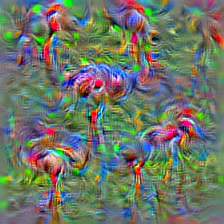

In [15]:
pret_mod =  models.vgg19(pretrained=True)
target_class = 130  # Flamingo
iterations=150
blur_freq=4
blur_rad=1
wd=0.0001
clipping_value=0.1
initial_learning_rate = 6
pretrained_model = models.alexnet(pretrained=True)
def regularized_class_img_gen(pretrained_model, target_class, iterations, blur_freq, blur_rad, wd, clipping_value, initial_learning_rate):
  csig = RegularizedClassSpecificImageGeneration(pretrained_model, target_class, iterations, blur_freq, blur_rad, wd, clipping_value, initial_learning_rate)
  images = csig.generate()
  return images
images = regularized_class_img_gen(pretrained_model, target_class, iterations, blur_freq, blur_rad, wd, clipping_value, initial_learning_rate)
images[9]

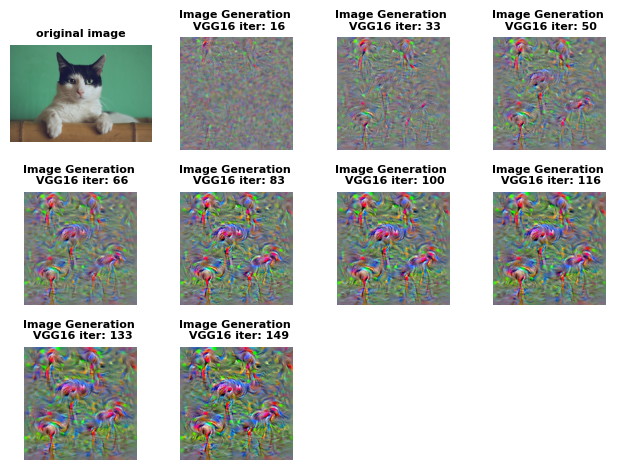

In [19]:
imgs = [img]
imgs = imgs + images
captions = ['original image'] + ['Image Generation \n VGG16 iter: ' + str(i) for i in [16, 33, 50, 66, 83, 100, 116, 133, 149, 165]]
fig = download_images(imgs, captions, cols = 4, rows = 3, size = 8)

In [17]:
len(images)

10